# Cazando al wumpus

In [1]:
# define rutas de trabajo e importa ambiente de trabajo
import os
import sys

CURRENT_PATH = os.getcwd()
NOTEBOOKS_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'notebooks')
PYTHON_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'python')
sys.path.append(PYTHON_PATH)

from logica import *
from entornos import *
from wkb import *
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt

from busqueda import best_first_search, solucion, breadth_first_search

### Detectando al wumpus

In [222]:
# crea la base de conocimientos de alerta de wumpus

def alerta_wumpus(self):
    x, y = self.loc
    turno = self.turno
    formulas = []
    formulas += [
        f'en({x},{y})_{turno}Yhedor_{turno}>alerta_wumpus({x},{y})',  
    ]
    return formulas

setattr(Agente_wkb, 'alerta_wumpus', alerta_wumpus)


In [256]:
# guarda casillas donde detecto wumpus

def consulta_alerta(self):
	'''
	identifica y retorna las casillas en donde es posible que el wumpus esta.
	Es necesario que la base de conocimientos tenga la cabeza de ASK ya creada.
	'''
	turno = self.turno
	x, y = self.loc

	def truncar(x):
		if x < 0:
			return 0
		elif x > 3:
			return 3
		else:
			return x

	def adyacentes(casilla):
		x, y = casilla
		adyacentes = [
			(truncar(x - 1), y), (truncar(x + 1), y),
			(x, truncar(y - 1)), (x, truncar(y + 1))
		]
		adyacentes = [c for c in adyacentes if c != casilla]
		return adyacentes
	
	casillas = adyacentes(self.loc)
	consulta_alertas = []
	
	consulta = ASK(f'alerta_wumpus({x},{y})', 'success', self.base)
	if consulta:
		for c in casillas:
			x1, y1 = c
			consulta_alertas.append(f'alerta_wumpus({x1},{y1})_{turno}')
			
	return consulta_alertas

setattr(Agente_wkb, 'consulta_alerta', consulta_alerta)

In [257]:
# modifica el metodo `estimar_estado_wkb` para incluir 
# `alerta_wumpus`
# `consulta_alerta`

def estimar_estado_wkb2(self, W):
    self.base.TELL(f'segura({self.loc[0]},{self.loc[1]})')
    cas_seguras = self.adyacentes_seguras_wkb()
    self.base.TELL('Y'.join([f'segura({c[0]},{c[1]})' for c in cas_seguras]))
    nueva_dir = self.nueva_direccion_wkb()
    self.base.TELL(nueva_dir)
    nueva_pos = self.nueva_posicion_wkb()
    self.base.TELL(nueva_pos)
    formulas = [d for d in self.base.datos if f'_{self.turno}' in d]
    formulas += [s for s in self.base.datos if 'segura' in s]
    formulas += self.fluentes_mapa_mental_wkb()
    formulas += self.brisa_pozo_wkb()
    formulas += self.hedor_wumpus_wkb()
    formulas += self.casilla_segura_wkb()
    formulas += self.casillas_visitadas_wkb()
    formulas += self.alerta_wumpus() # new
    self.perceptos = W.para_sentidos()
    formulas += [self.interp_percepto_wkb(mundo='wumpus')]
    self.base = LPQuery(formulas)

setattr(Agente_wkb, 'estimar_estado_wkb', estimar_estado_wkb2)


#### Prueba manual

In [258]:
W = Wumpus(wumpus=(1,1), oro=(2,3), pozos=[(0,3), (3,3)])
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus() # new
formulas += agente.consulta_alerta() # new
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.perceptos = W.para_sentidos()
agente.base = LPQuery(formulas)
print("¡Base de conocimiento creada!")
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)

consulta_alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta

agente.turno += 1
a ='adelante'
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
W.transicion(a)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta() # con la base de conocimiento actual, evalua hedor y crea lista de posibles lugares para el wumpus

agente.turno += 1
a ='adelante'
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
W.transicion(a)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()

agente.turno += 1
a ='voltearIzquierda'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()


agente.turno += 1
a ='adelante'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()

print("***listado de alertas***")
print(consulta_alertas)

¡Base de conocimiento creada!
***listado de alertas***
['alerta_wumpus(0,0)_2', 'alerta_wumpus(2,0)_2', 'alerta_wumpus(1,1)_2', 'alerta_wumpus(1,1)_5', 'alerta_wumpus(3,1)_5', 'alerta_wumpus(2,0)_5', 'alerta_wumpus(2,2)_5']


<AxesSubplot:>

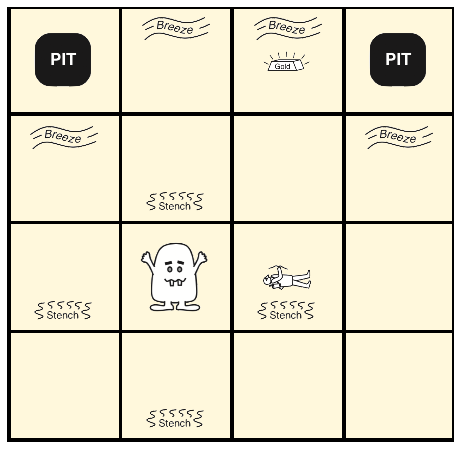

In [236]:
W.pintar_todo()

#### Prueba con programa de agente

In [259]:
def programaKB(self, DEB=False):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()
    if DEB:
        print('Turno acutal:', turno)
        print('Casilla actual:', casilla_actual)
        print('Dirección actual:', direccion)
        print('Casillas adyacentes seguras:', cas_seguras)
        print('Casillas visitadas:', cas_visitadas)
    if ASK(f'brillo_{turno}','success',self.base):
        if DEB:
            print('¡Oh, el oro!')
    else:
        opciones = [casilla for casilla in cas_seguras if casilla not in cas_visitadas]
        if DEB:
            print('Casillas opcionales:', opciones)
        if len(opciones) > 0:
            casilla_ir = choice(opciones)
            if DEB:
                print('El agente quiere ir a la casilla', casilla_ir)
            camino = [casilla_actual, casilla_ir]
            acciones = acciones_camino(camino, direccion)
        elif len(cas_seguras) > 0:
            print('no hay mas opciones')
            casilla_ir = choice(cas_seguras)
            if DEB:
                print('El agente quiere devolverse a la casilla', casilla_ir)
            camino = [casilla_actual, casilla_ir]
            acciones = acciones_camino(camino, direccion)
        else:
            print("¡Caso no contemplado!")
    self.acciones += acciones

setattr(Agente_wkb, 'programa', programaKB)

In [278]:
# guarda casillas donde detecto wumpus

def consulta_alerta(self):
	'''
	identifica y retorna las casillas en donde es posible que el wumpus esta.
	Es necesario que la base de conocimientos tenga la cabeza de ASK ya creada.
	'''
	turno = self.turno
	x, y = self.loc
	#visitadas = []
	visitadas = self.todas_seguras_wkb()

	def truncar(x):
		if x < 0:
			return 0
		elif x > 3:
			return 3
		else:
			return x

	def adyacentes(casilla):
		x, y = casilla
		adyacentes = [
			(truncar(x - 1), y), (truncar(x + 1), y),
			(x, truncar(y - 1)), (x, truncar(y + 1))
		]
		adyacentes = [c for c in adyacentes if c != casilla]
		return adyacentes
	
	casillas = adyacentes(self.loc)
	consulta_alertas = []
	
	consulta = ASK(f'alerta_wumpus({x},{y})', 'success', self.base)
	if consulta:
		for c in casillas:
			x1, y1 = c
			consulta_alertas.append(f'alerta_wumpus({x1},{y1})')
			if c in visitadas:
				x1, y1 = c
				consulta_alertas.remove(f'alerta_wumpus({x1},{y1})')
			
	return consulta_alertas

setattr(Agente_wkb, 'consulta_alerta', consulta_alerta)

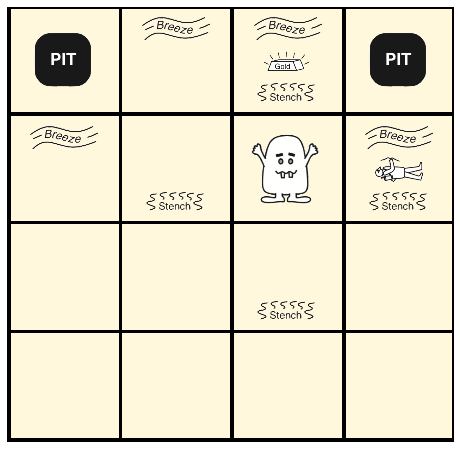

***listado de alertas***
['alerta_wumpus(2,2)', 'alerta_wumpus(1,3)', 'alerta_wumpus(2,2)', 'alerta_wumpus(1,3)', 'alerta_wumpus(2,2)', 'alerta_wumpus(1,3)', 'alerta_wumpus(2,2)', 'alerta_wumpus(1,3)', 'alerta_wumpus(2,2)', 'alerta_wumpus(1,3)', 'alerta_wumpus(3,1)', 'alerta_wumpus(2,2)', 'alerta_wumpus(3,1)', 'alerta_wumpus(2,2)', 'alerta_wumpus(3,1)', 'alerta_wumpus(2,2)', 'alerta_wumpus(2,2)', 'alerta_wumpus(3,3)']
***visitadas***
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]


In [294]:

W = Wumpus(wumpus=None, oro=(2,3), pozos=[(0,3), (3,3)])
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)
print("¡Base de conocimiento creada!")

consulta_alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta

for i in range(40):
    a = agente.reaccionar_wkb()
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
    if not W.juego_activo:
        clear_output(wait=True)
        W.pintar_todo()
        print(W.mensaje)
        break
    agente.estimar_estado_wkb(W)
    consulta_alertas += agente.consulta_alerta()
    clear_output(wait=True)
    W.pintar_todo()
    plt.show()
    sleep(.25) 

print("***listado de alertas***")
print(consulta_alertas)

print("***visitadas***")
print(agente.todas_seguras_wkb())

In [295]:
from collections import Counter
Counter(consulta_alertas)

Counter({'alerta_wumpus(2,2)': 9,
         'alerta_wumpus(1,3)': 5,
         'alerta_wumpus(3,1)': 3,
         'alerta_wumpus(3,3)': 1})

la casilla con mayor cantidad de alarmas, es la mas probable en donde esté el wumpus.